Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Epoch 1/20
1/1 [==============================] - 18s 18s/step - loss: 1.1316 - val_loss: 0.2962
Epoch 2/20
1/1 [==============================] - 12s 12s/step - loss: 0.3148 - val_loss: 0.1606
Epoch 3/20
1/1 [==============================] - 11s 11s/step - loss: 0.1575 - val_loss: 0.1652
Epoch 4/20
1/1 [==============================] - 14s 14s/step - loss: 0.1719 - val_loss: 0.1225
Epoch 5/20
1/1 [==============================] - 23s 23s/step - loss: 0.1149 - val_loss: 0.1059
Epoch 6/20
1/1 [==============================] - 13s 13s/step - loss: 0.0986 - val_loss: 0.0969
Epoch 7/20
1/1 [==============================] - 10s 10s/step - loss: 0.0813 - val_loss: 0.0833
Epoch 8/20
1/1 [==============================] - 14s 14s/step - loss: 0.0636 - val_loss: 0.0821
Epoch 9/20
1/1 [==============================] - 12s 12s/step - loss: 0.0559 - val_loss: 0.0

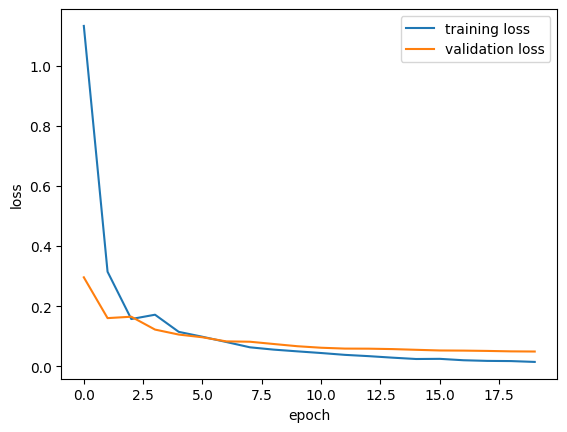

In [1]:
from google.colab import drive

drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/MyDrive/')

import os
import h5py
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Directory where the images and density maps are stored
data_dir = "/content/drive/MyDrive/grape"

# Get a list of filenames for the input images and density maps
image_filenames = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.jpg')]
density_map_filenames = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.h5')]

# Load the images and their corresponding density maps
images = []
density_maps = []
for image_filename, density_map_filename in zip(image_filenames, density_map_filenames):
    # Load the image and resize to (224,224)
    image = load_img(image_filename, target_size=(224, 224))
    # Convert the image to a numpy array
    x = img_to_array(image)
    # Preprocess the input by subtracting the mean RGB pixel intensity of the ImageNet dataset
    x = tf.keras.applications.vgg16.preprocess_input(x)
    images.append(x)

    # Load the density map and resize to (7,7,1)
    with h5py.File(density_map_filename, 'r') as f:
        density_map = np.array(f['density'])
        density_map = cv2.resize(density_map, (7,7))
        # Reshape density map to (7,7,1)
        density_map = np.reshape(density_map, (7,7,1))
        density_maps.append(density_map)

features = np.array(images)
target = np.array(density_maps)

# Split the data into training and validation sets using the validation_split argument in the model.fit function
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert X_train and y_train to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

# Reshape X_train and y_train to match the input and output shape of the model
X_train = tf.reshape(X_train, (-1, X_train.shape[1], X_train.shape[2], 3))
y_train = tf.reshape(y_train, (-1, y_train.shape[1], y_train.shape[2], 1))

# Define the GBCNet model
vgg = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=X_train[0].shape)

for layer in vgg.layers:
    layer.trainable = False

input_layer = vgg.input
block5_pool = vgg.get_layer('block5_pool').output

conv1 = tf.keras.layers.Conv2D(512, (3,3), dilation_rate=(2,2), padding='same', activation='relu')(block5_pool)
conv2 = tf.keras.layers.Conv2D(512, (3,3), dilation_rate=(2,2), padding='same', activation='relu')(conv1)
conv3 = tf.keras.layers.Conv2D(512, (3,3), dilation_rate=(2,2),padding='same', activation='relu')(conv2)
conv4 = tf.keras.layers.Conv2D(256, (3,3), dilation_rate=(2,2), padding='same', activation='relu')(conv3)
conv5 = tf.keras.layers.Conv2D(128, (3,3), dilation_rate=(2,2), padding='same', activation='relu')(conv4)
conv6 = tf.keras.layers.Conv2D(64, (3,3), dilation_rate=(2,2), padding='same', activation='relu')(conv5)
conv7 = tf.keras.layers.Conv2D(1, (1,1), padding='same', activation='linear')(conv6)

gbcnet = tf.keras.models.Model(inputs=input_layer, outputs=conv7)

# Compile the model
gbcnet.compile(loss='MAE', optimizer=Adam(learning_rate=1e-4))

# Train the model
history = gbcnet.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16, verbose=1)

# Plot the loss and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [2]:
# Evaluate the model on the training set
y_train_pred = gbcnet.predict(X_train)

# Reshape a 4D array to a 2D array
y_train_2d = np.reshape(y_train, (-1,))
y_train_pred_2d = np.reshape(y_train_pred, (-1,))

# Compute mean squared error and mean absolute error on the training set
mse_train = mean_squared_error(y_train_2d, y_train_pred_2d)
mae_train = mean_absolute_error(y_train_2d, y_train_pred_2d)

# Print the results on the training set
print("Mean Absolute Error on training set: {:.5f}".format(mae_train))
print("Mean Squared Error on training set: {:.5f}".format(mse_train))

# Evaluate the model on the validation set
y_val_pred = gbcnet.predict(X_val)

# Reshape a 4D array to a 2D array
y_val_2d = np.reshape(y_val, (-1,))
y_val_pred_2d = np.reshape(y_val_pred, (-1,))

# Compute mean squared error and mean absolute error on the validation set
mse_val = mean_squared_error(y_val_2d, y_val_pred_2d)
mae_val = mean_absolute_error(y_val_2d, y_val_pred_2d)

# Print the results on the validation set
print("Mean Absolute Error on validation set: {:.5f}".format(mae_val))
print("Mean Squared Error on validation set: {:.5f}".format(mse_val))


1/1 [==============================] - 9s 9s/step
Mean Absolute Error on training set: 0.01408
Mean Squared Error on training set: 0.00037
1/1 [==============================] - 2s 2s/step
Mean Absolute Error on validation set: 0.04958
Mean Squared Error on validation set: 0.00379
